In [90]:
import numpy as np
import pandas as pd
import os
import sys
import time
import logging
import importlib
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_fscore_support, 
    accuracy_score, 
    classification_report, 
    confusion_matrix
)

random.seed(123)
pct_anomalies = 0.01

In [91]:
for dirname, _, filenames in os.walk(r"\Kaggle"):
    for filename in filenames:
        print(filename)

corrected.gz
kddcup.data.corrected
kddcup.data.gz
kddcup.data_10_percent.gz
kddcup.data_10_percent_corrected
kddcup.names
kddcup.newtestdata_10_percent_unlabeled.gz
kddcup.testdata.unlabeled.gz
kddcup.testdata.unlabeled_10_percent.gz
training_attack_types
typo-correction.txt
corrected
kddcup.data
kddcup.data_10_percent
kddcup.newtestdata_10_percent_unlabeled
kddcup.testdata.unlabeled
kddcup.testdata.unlabeled_10_percent


In [92]:
# Check if running in a Jupyter notebook environment
if 'ipykernel' in sys.modules:
    pct_anomalies = 0.01
else:
    parser = argparse.ArgumentParser() 
    parser.add_argument('--pct_anomalies', default=.01, type=float) 
    pct_anomalies = args.pct_anomalies

In [93]:
data_path = r'Kaggle\kddcup.data.corrected'  

col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate","label"]



# df = pd.read_csv(data_path,names=col_names, index_col=False) 

df = pd.read_csv(data_path, names=col_names, nrows=100000)

In [94]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [95]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [96]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [97]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,100000.00000,100000.000000,100000.000000,100000.0,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,3.34104,515.984370,3243.426320,0.0,0.0,0.000010,0.034240,0.000020,0.757570,0.005720,...,150.914640,241.165270,0.978821,0.004817,0.273152,0.017744,0.001075,0.000431,0.000784,0.000779
std,215.99869,735.447971,8010.090009,0.0,0.0,0.003162,0.783705,0.004472,0.428555,0.930568,...,106.179572,47.581315,0.109489,0.031200,0.414371,0.029849,0.018554,0.014061,0.027582,0.027656
min,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,222.000000,241.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,34.000000,255.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,293.000000,853.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,178.000000,255.000000,1.000000,0.000000,0.030000,0.010000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,1032.000000,2712.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,0.500000,0.030000,0.000000,0.000000,0.000000,0.000000
max,40504.00000,49765.000000,271733.000000,0.0,0.0,1.000000,30.000000,1.000000,1.000000,217.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.940000,1.000000,1.000000


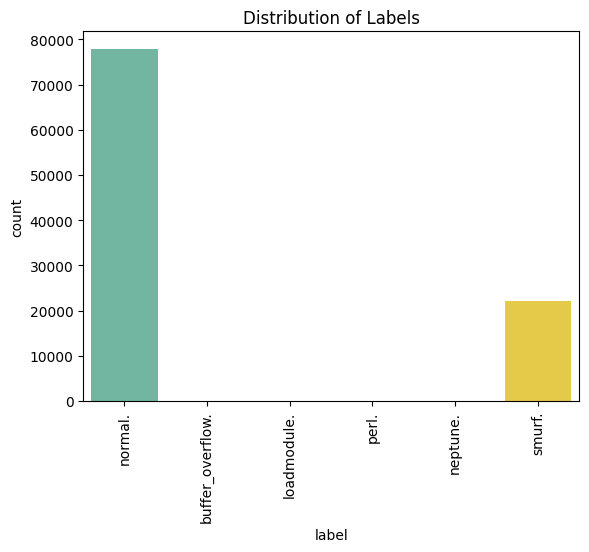

In [98]:
sns.countplot(data=df, x='label', hue='label', palette='Set2', legend=False)
plt.xticks(rotation=90)
plt.title('Distribution of Labels')
plt.show()



In [99]:
# Encode target
le = LabelEncoder()
le.fit(df['label'])
integer_labels = le.transform(df['label'])

In [100]:
# Categorical variable encoding
cat_vars = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
cat_data = pd.get_dummies(df[cat_vars])

In [101]:
# Numeric data
numeric_vars = list(set(df.columns) - set(cat_vars) - {'label'})
numeric_data = df[numeric_vars].copy()


In [102]:
# Combine numeric and encoded categorical data
numeric_cat_data = pd.concat([numeric_data, cat_data], axis=1)

In [103]:
# Normal = 0, Attack = 1
y = integer_labels.copy()
y[y != le.transform(['normal.'])[0]] = 1
y[y == le.transform(['normal.'])[0]] = 0

In [104]:
# TRAIN / TEST SPLIT
x_train, x_test, y_train, y_test = train_test_split(numeric_cat_data, y, test_size=0.25, random_state=42)

# Use only normal data (label=0) for training
x_train = x_train[y_train == 0]

In [105]:
# SCALING
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [106]:
# ISOLATION FOREST
iso_forest = IsolationForest(n_estimators=100, contamination=pct_anomalies, random_state=42)
iso_forest.fit(x_train_scaled)


,n_estimators,100
,max_samples,'auto'
,contamination,0.01
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [107]:
# Predict on test set
y_pred_test = iso_forest.predict(x_test_scaled)

In [108]:
# Map predictions to binary: -1 → anomaly (1), 1 → normal (0)
predicted_labels = np.where(y_pred_test == -1, 1, 0)

In [109]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted_labels, average='binary')
print("=== Isolation Forest Results ===")
print("Accuracy Score :", accuracy_score(y_test, predicted_labels))
print("Precision      :", precision)
print("Recall         :", recall)
print("F1 Score       :", f1)


=== Isolation Forest Results ===
Accuracy Score : 0.77436
Precision      : 0.275092936802974
Recall         : 0.013405797101449275
F1 Score       : 0.025565728105026775


In [110]:
print("\nClassification Report:\n", classification_report(y_test, predicted_labels))


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.99      0.87     19480
           1       0.28      0.01      0.03      5520

    accuracy                           0.77     25000
   macro avg       0.53      0.50      0.45     25000
weighted avg       0.67      0.77      0.69     25000



In [111]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Oranges):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Normal', 'Anomaly'], rotation=45)
    plt.yticks(tick_marks, ['Normal', 'Anomaly'])

    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

Confusion Matrix:


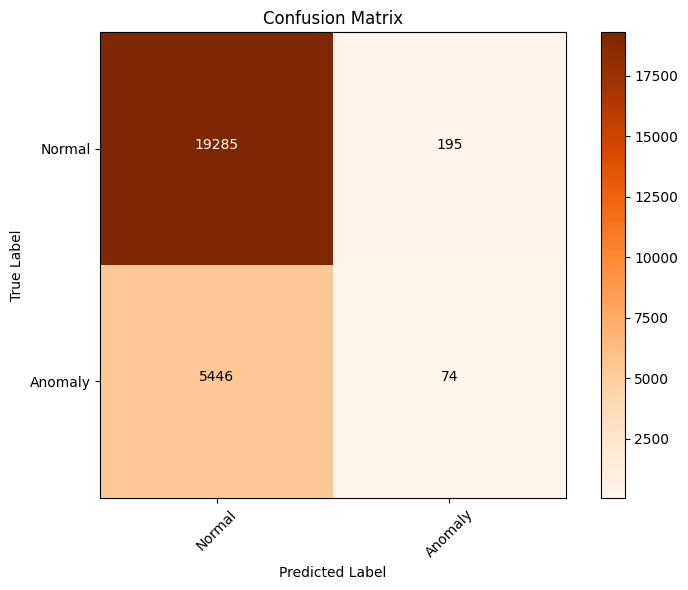

In [112]:
cm = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:")
plot_confusion_matrix(cm)
plt.show()